# **ENGG680 - Introduction to Digital Engineering**
## *Lab Assignment 3: Introduction to Machine Learning (Gradient Descent, Logistic Regression)*

## Preliminary: Certificate of Work


*We, the undersigned, certify that this is our own work, which has been done expressly for this course, either without the assistance of any other party or where appropriate we have acknowledged the work of others. Further, we have read and understood the section in the university calendar on plagiarism/cheating/other academic misconduct and we are aware of the implications thereof. We request that the total mark for this assignment be distributed as follows among group members:*

|          | First Name | Last Name | Signature (Full Name, Date) | Hours | Contribution % |
|----------|------------|-----------|-----------------------------|-------|----------------|
| Member 1: | Katia | Abdul Baki | Katia Abdul Baki, 11-08-2024 | 7 | 25% |
| Member 2: | Malay | Mistry | Malay Mistry, 11-08-2024| 2 | 25% |
| Member 3: | Pratham | Rami | Pratham Rami, 11-08-2024 | 7 | 25% |
| Member 4: | Vasu | Shah | Vasu Shah, 11-08-2024 | 5 | 25% |


# **Non-linear Gradient Descent (25 marks)**

### **Observations:** Pseudorange [m]

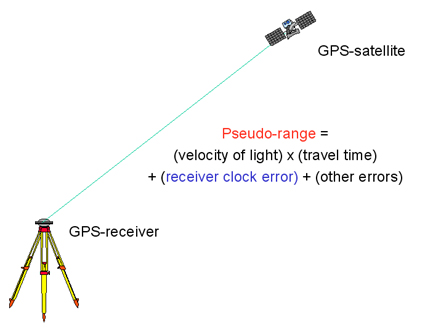

<font size="1.5">Image source: *ICA Course on Toponymy. https://unstats.un.org/unsd/geoinfo/ungegn/docs/_data_icacourses/_HtmlModules/_Selfstudy/S06/S06_05b.html.*</font>

**Pseudorange** is the *pseudo* distance between a satellite and a satellite signal receiver on the ground. In simple words, it contains the geometric range between the satellite and the receiver, with additional associated errors.

The simplified version of the Pseudorange measurement model is:
$$P=\rho-cdT+ϵ_{sum}$$ and
$$\rho=\sqrt{(x_s - x_r)^2 + (y_s - y_r)^2 + (z_s - z_r)^2}$$
where
$$\rho=geometric\ range$$
$${x_s, y_s, z_s, x_r,y_r,z_r} = 3D\ coordinates\ of\ satellite\ and\ receiver$$
$$cdT = receiver\ clock\ offset$$
$$ϵ_{sum}=general\ errors\ term\ (ϵ_{sum}=\Delta \rho + \Delta_{\text{ion}} + \Delta_{\text{trop}} + \epsilon_P + cdt)$$

\\
Note: the 3D **positions of satellites** are given in this assignment.

### **Unknown States:** Position of receiver & receiver clock offset

We use the psuedorange measurements to estimate the receiver's **3-dimensional position** and the **receiver clock offset:** $$X={x_r,y_r,z_r,cdT}$$.

These will be our states of interest, and we are going to estimate them using Gradient Descent method


.

###Step 0: Setup & Intialization

Step 0.1: Import necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Step 0.2: Read and parse data files

In [2]:
from google.colab import drive
drive.mount('/content/drive')

df_pseudorange = pd.read_excel('/content/drive/MyDrive/engg680_2024_fall/Lab_Assignment3/pseudoranges1.xlsx')
df_sat_pos = pd.read_excel('/content/drive/MyDrive/engg680_2024_fall/Lab_Assignment3/satellite_position1.xlsx')

pseudorange = df_pseudorange['P'].to_numpy()
sat_pos =df_sat_pos[['x','y','z']].to_numpy()

n = pseudorange.size

Mounted at /content/drive


Step 0.3: Define the groundtruth of receiver's position in ECEF (m)

In [3]:
GroundTruth=np.array([-1633489.37967725,	-3651627.18250363,	4952481.61954918])

Step 0.4: Intialize empty arrays

In [4]:
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

Step 0.5: Function that
computes the euclidean distance between satellite and receiver

In [5]:
def euclidean_norm(receiver_pos, satellite_pos):

    # Calculate the Euclidean norm (distance)
    distance = np.linalg.norm(satellite_pos - receiver_pos, axis =1)

    return distance


### Step 1: Define the Cost Function (4 marks)
Define a cost function that computes the sum of squared residuals between measured and predicted pseudoranges.

The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.

The function returns a single scalar.

Call euclidean_norm function to calculate geometric distance.

In [6]:
# Cost function: sum of squared residuals between measured and predicted pseudoranges
def cost_function(r_pos, cdT, s_pos, pseudorange):
    geometric_distance = euclidean_norm(r_pos, s_pos)
    predicted_pseudorange = geometric_distance - cdT
    residuals = pseudorange - predicted_pseudorange
    cost = (1/n) * np.sum(residuals**2)

    return cost

### Step 2: Define the Gradient Computation Function (4 marks)

Define a gradient computation function that calculates the gradient of the cost function with respect to the estimates (x_r, y_r, z_r, cdT).


The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.


The function returns a 1D numpy array that contains 4 elements.


Call euclidean_norm function to calculate geometric distance.


In [7]:
# Gradient of the cost function with respect to the unknowns (x_r, y_r, z_r, cdT)
def gradient(r_pos, cdT, s_pos, pseudorange):
    geometric_distance = euclidean_norm(r_pos, s_pos)
    predicted_pseudorange = geometric_distance - cdT
    residuals = pseudorange - predicted_pseudorange
    grad_x_r = (-2/n) * np.sum(residuals * (r_pos[0] - s_pos[:,0]) / geometric_distance)
    grad_y_r = (-2/n) * np.sum(residuals * (r_pos[1] - s_pos[:,1]) / geometric_distance)
    grad_z_r = (-2/n) * np.sum(residuals * (r_pos[2] - s_pos[:,2]) / geometric_distance)
    grad_cdt = (-2/n) * -np.sum(residuals)
    grad = np.array([grad_x_r, grad_y_r, grad_z_r, grad_cdt])
    return grad

### Step 3: Gradient Descent Implementation (4 marks)
Construct the implementation function of gradient descent

Replace '...' with actual implementation

The function's input are: observed pseudoranges, satellites' positions, learning_rate, maximum loop iterations, tolerance

The function will return a 1D numpy array that contains the optimized estimates (x_r, y_r, z_r, cdT)

The function set learning_rate, max_iters and tolerance as: 0.01, 100000, 1e-6 as default values

These default hyperparameters values can be overridden by passing your own values when calling the function


In [8]:
# Gradient descent algorithm for non-linear least squares estimation
def gradient_descent(pseudorange, s_pos, learning_rate=0.1, max_iters=10000, tolerance=1e-6):

    global steps_count
    print(learning_rate)
    #initalize the estimates as zeros
    X = np.array([0,0,0,0])

    for iteration in range(max_iters):
        r_pos = X[:3]
        cdT = X[3]

        # compute the cost in the current step
        # (1 mark)
        current_cost = cost_function(r_pos, cdT, s_pos, pseudorange)

        # compute the gradients in the current step
        # (1 mark)
        grad = gradient(r_pos, cdT, s_pos, pseudorange)


        # update estimates
        # (1 mark)
        X_new = X - learning_rate * grad

        # compute the new cost
        # (1 mark)
        new_cost = cost_function(X_new[:3], X_new[3], s_pos, pseudorange)

        # break the loop if converge
        if np.abs(new_cost - current_cost) < tolerance:
            print("Converged !")
            steps_count=iteration
            break

        # update the parameters for the next iteration
        X = X_new

        #collect intermediate results for cost and gradients
        arr_cost.append(current_cost)
        arr_grad.append(grad)
        arr_err.append(X[:3]-GroundTruth)

    return X, arr_cost, arr_grad, arr_err

### Step 4: Parameters Optimization & Results Printing (3 marks)

Call *gradient_descent* function to optimize the estimating parameters using default optimization hyperparameters

Print:

*   optimized parameters
*   final position errors of receiver
*   number of steps taken for convergence
*   final cost value
*   final gradient values








In [9]:
optimized_params, arr_cost, arr_grad, arr_err = gradient_descent(pseudorange, sat_pos)
final_position_errors = arr_err[-1]
final_cost = arr_cost[-1]
final_gradient = arr_grad[-1]

# print the mentioned metrics
print("Optimized Parameters:", optimized_params)
print("Final Position Errors:", final_position_errors)
print("Number of Steps:", steps_count)
print("Final Cost:", final_cost)
print("Final Gradient:", final_gradient)

0.1
Converged !
Optimized Parameters: [-1.63349244e+06 -3.65162953e+06  4.95248539e+06 -6.44838347e+00]
Final Position Errors: [-3.06240566 -2.34631388  3.77147769]
Number of Steps: 2963
Final Cost: 0.5634455009259777
Final Gradient: [ 0.00015542  0.00086601 -0.00266161  0.00150894]


### Step 5: Cost vs Steps Plot & Analysis (2 marks)
Plot cost vs steps

Use 'semilogy' to scale y-axis

Label each axis

Include figure title

Comment on the pattern from the plot

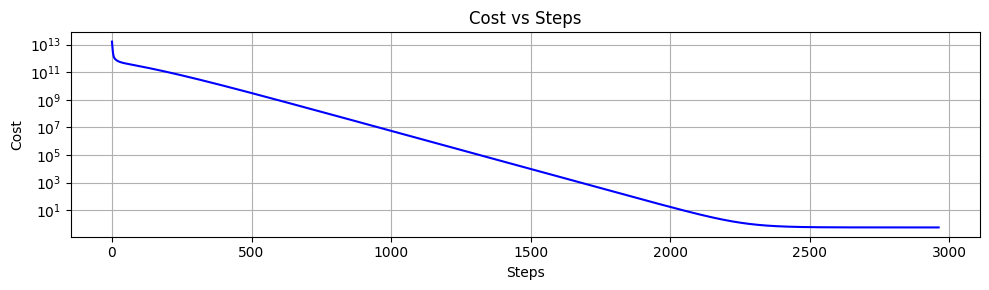

In [10]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))
ax.semilogy(arr_cost, linestyle='-', color='b')
ax.set_xlabel('Steps')
ax.set_ylabel('Cost')
ax.set_title('Cost vs Steps')
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
# Here, the cost function decreases as number of steps increases which indicates that the algorithm is learning and improving it's ability to predict values.

### Step 6: Gradients vs Steps & Analysis(2 marks)
Plot gradients vs steps

use 'symlog' to scale y-axis

use 'tick_params' and set y-axis: labelsize=8

include axes' labels, legends and title

Comment on the pattern from the plot

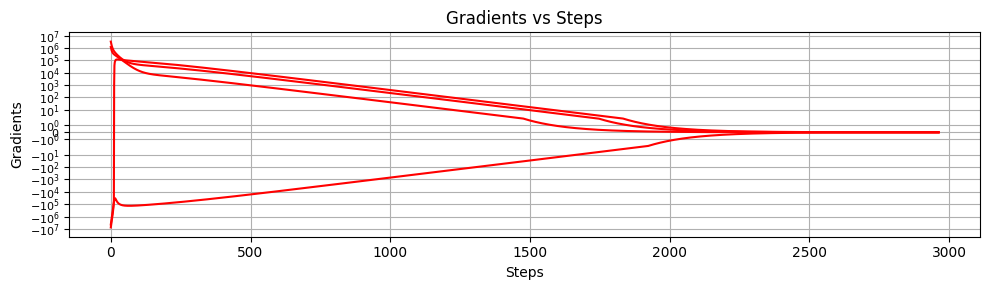

In [11]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))
ax.plot(arr_grad, linestyle='-', color='red')
ax.set_yscale('symlog')
ax.tick_params(axis='y', labelsize=8)
ax.set_xlabel('Steps')
ax.set_ylabel('Gradients')
ax.set_title('Gradients vs Steps')
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
# Here, the gradients converge to zero after around 2200 steps which means that the model is learning and improving.

### Step 7: Positioning errors vs Steps & Analysis(2 marks)
Plot positioning errors vs steps

Include axes' labels, legends and title

Comment on the pattern of the plot

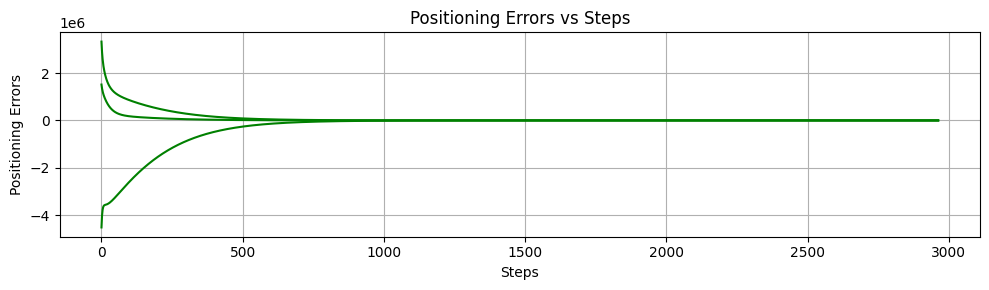

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.plot(arr_err, linestyle='-', color='green')
ax.set_xlabel('Steps')
ax.set_ylabel('Positioning Errors')
ax.set_title('Positioning Errors vs Steps')
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
# Here, the pattern suggests that the system is converging on a stable and accurate position. The slight oscillations around zero indicate that the system may be experiencing some minor fluctuations, but these are relatively small and the overall trend is towards a very accurate position..

# Hyperparameters Tuning

### Step 8: Tuning Learning rate (2 marks)

Change learning rate to 0.01, 0.001 and repeat step 4.

(*hint: you may need to adjust the maximum loop iterations in this case*)

In [13]:
#set learning rate to 0.01
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

optimized_params_2, arr_cost, arr_grad, arr_err = gradient_descent(pseudorange, sat_pos,0.01)
final_position_errors = arr_err[-1]
final_cost = arr_cost[-1]
final_gradient = arr_grad[-1]
# print the metrics
print("Optimized Parameters:", optimized_params_2)
print("Final Position Errors:", final_position_errors)
print("Number of Steps:", steps_count)
print("Final Cost:", final_cost)
print("Final Gradient:", final_gradient)

0.01
Optimized Parameters: [-1632831.67478494 -3647949.08713054  4941174.43755047     6408.12065437]
Final Position Errors: [   657.70489231   3678.09537309 -11307.18199871]
Number of Steps: 0
Final Cost: 5811214.800020539
Final Gradient: [  41.92321297  233.42556734 -717.34025119  406.94266989]


In [14]:
from typing_extensions import final
#set learning rate to 0.001
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

optimized_params_3, arr_cost, arr_grad, arr_err = gradient_descent(pseudorange, sat_pos,0.001)
final_position_errors = arr_err[-1]
final_cost = arr_cost[-1]
final_gradient = arr_grad[-1]
# print the metrics
print("Optimized Parameters:", optimized_params_3)
print("Final Position Errors:", final_position_errors)
print("Number of Steps:", steps_count)
print("Final Cost:", final_cost)
print("Final Gradient:", final_gradient)

0.001
Optimized Parameters: [-1456131.06049278 -2794627.49109828  2359993.40248177  1573224.39421376]
Final Position Errors: [  177358.31918447   856999.69140535 -2592488.21706741]
Number of Steps: 0
Final Cost: 268883860080.11005
Final Gradient: [  15285.11418968   44818.48906819 -125160.04736353   81661.68993389]


## Step 9: Results Analysis (2 marks)

Q1. Comment on the difference that you notice after changing the learning rate. (1 mark)

Q2. What is the difference between LSE and Gradient Descent? (Comment based on your results and the methodology) (1 mark)



ANSWER HERE

1. After changing the learning rate, the value of output decreases which means that the output is becoming more accurate with less learning rate.


2. LSE is mainly used for estimating parameters of a linear model, while Gradient Descent is an optimization algorithmn.

---
---

# **Logistic Regression (50 marks)**

The following dataset helps to predict phishing webpages. It is collected mainly from: PhishTank archive, MillerSmiles archive, Googleâ€™s searching operators.

It can be downloaded from : https://archive.ics.uci.edu/dataset/327/phishing+websites

<u>Class labels:</u>

Not phishing = -1

Phishing = 1



Follow the steps provided to perform binary classification using logistic regression and complete the code for each part.


### Step 0: Import Libraries

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Data Input (2 mark)

Use the `fetch_ucirepo(id=<ID>)`  to load the phishing dataset (id = 327) as a dataframe into the feature matrix `X` and target vector `y`.

Print the size of `X` and `y`


In [16]:
!pip install ucimlrepo

In [17]:
from ucimlrepo import fetch_ucirepo

# Below code fetches dataset
phishing_websites = fetch_ucirepo(id=327)

# TO DO: data (as pandas dataframes) (1 mark)

data = pd.DataFrame(phishing_websites.data.features, columns=phishing_websites.feature_names)


# TO DO: display sizes of X and y (1 mark)

print(data.shape)



(11055, 30)


### Step 2.1: Class label histogram (2 marks)

Plot the histogram for each class label to visualise class imbalance. Additionally before calling .show() for the plot, ensure that the code displays you the exact value of the samples for each class above the respective bins.

statistical_report
 1    9505
-1    1550
Name: count, dtype: int64


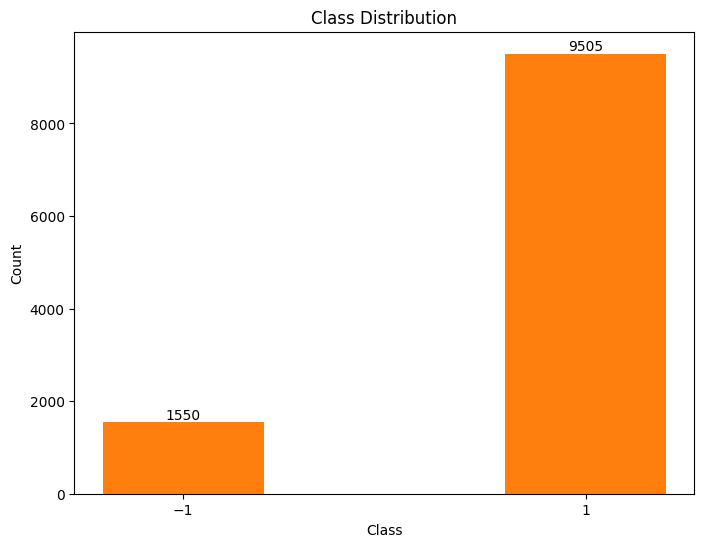

In [18]:
# TO DO: Check the class distribution of y (2 mark)
y=data.iloc[:,-1]

class_distribution = y.value_counts()
print(class_distribution)
# TO DO: Plot the histogram of y (2 mark)
# Display exact values for each bin in the histogram

plt.figure(figsize=(8, 6))
bars = plt.bar(class_distribution.index, class_distribution.values)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')
plt.bar(class_distribution.index, class_distribution.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(class_distribution.index)
plt.show()

### Step 2.2: Smaller dataset creation(2 mark)


We also want to test if the model would still work if we used less data. Use the `train_test_split` function from sklearn to create a new feature matrix named `X_small` and a new target vector named `y_small` that contain **3%** of the data.

Use random_state = 42


In [24]:
from re import X
from sklearn.model_selection import train_test_split
from ucimlrepo import fetch_ucirepo

phishing_webpages = fetch_ucirepo(id=327)
X = phishing_webpages.data.features
y = phishing_webpages.data.targets

y = y.values.ravel()

# TO DO: Create a smaller dataset with 3% of the data

X_small, _, y_small, _ = train_test_split(X, y, train_size=0.03, random_state=42)

# TO DO: display sizes of X_small and y_small (2 mark)
print("Size of X_small:", X_small.shape)
print("Size of y_small:", y_small.shape)


Size of X_small: (331, 30)
Size of y_small: (331,)


### Step 3: Implement Machine Learning Model (6 marks)

1. Import `LogisticRegression` from sklearn
2. Instantiate model `LogisticRegression(max_iter=2000)`
3. Implement the machine learning model with three different datasets:
    - `X` and `y` (1 mark)
    - Only first two columns of `X` and `y` (1 mark)
    - `X_small` and `y_small` (1 mark)

In [51]:
#STEP 3
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report)

model = LogisticRegression(max_iter=2000)
model.fit(X, y)
model.fit(X.iloc[:, :2], y)
model.fit(X_small, y_small)


LogisticRegression(max_iter=2000)

### Step 4: Test Model (6 x 3 = 18 marks)

Calculate the following for the **three different tests** implemented in Step 3
1. data size (1 mark)
1. number of training samples (1 mark)
2. number of testing samples (1 mark)
4. training accuracy (1 marks)
5. testing accuracy (1 marks)
6. log loss (1 mark)

In [61]:
#STEP 4
# Note: 70% training set, 30% testing set
# HINT: create a function that calculates all required information
from sklearn.metrics import log_loss

def evaluate_model(X_data, y_data, Datasets_name="model"):

    X_training, X_testing, y_training, y_testing = train_test_split(X_data, y_data, train_size=0.7, random_state=42)

    data_size = X_data.shape[0]
    print(f"{Datasets_name} - Data Size:", data_size)

    training_samples = X_training.shape[0]
    testing_samples = X_testing.shape[0]
    print(f"{Datasets_name} - Number of training samples:", training_samples)
    print(f"{Datasets_name} - Number of testing samples:", testing_samples)

    model.fit(X_training, y_training)

    training_accuracy = model.score(X_training, y_training)
    testing_accuracy = model.score(X_testing, y_testing)
    print(f"{Datasets_name} - Training Accuracy:", training_accuracy)
    print(f"{Datasets_name} - Testing Accuracy:", testing_accuracy)

    y_pred = model.predict_proba(X_testing)
    log_loss_value = log_loss(y_testing, y_pred)
    print(f"{Datasets_name} - Log Loss:", log_loss_value)
    print("\n")

    return data_size, training_samples, testing_samples, training_accuracy, testing_accuracy, log_loss_value

print(" Implement Machine Learning Model on Three Different Datasets:\n")

evaluate_model(X, y, Datasets_name="Complete Dataset for x and y")

evaluate_model(X.iloc[:, :2], y, Datasets_name="Two first columns of X and y")

evaluate_model(X_small, y_small, Datasets_name="Smaller Dataset X_small, y_small")

 Implement Machine Learning Model on Three Different Datasets:

Complete Dataset for x and y - Data Size: 11055
Complete Dataset for x and y - Number of training samples: 7738
Complete Dataset for x and y - Number of testing samples: 3317
Complete Dataset for x and y - Training Accuracy: 0.9311191522357198
Complete Dataset for x and y - Testing Accuracy: 0.9219173952366596
Complete Dataset for x and y - Log Loss: 0.1879422332411945


Two first columns of X and y - Data Size: 11055
Two first columns of X and y - Number of training samples: 7738
Two first columns of X and y - Number of testing samples: 3317
Two first columns of X and y - Training Accuracy: 0.5540191263892479
Two first columns of X and y - Testing Accuracy: 0.5773289116671692
Two first columns of X and y - Log Loss: 0.6773543714260858


Smaller Dataset X_small, y_small - Data Size: 331
Smaller Dataset X_small, y_small - Number of training samples: 231
Smaller Dataset X_small, y_small - Number of testing samples: 100
Small

(331, 231, 100, 0.948051948051948, 0.93, 0.19231080415833343)

### Step 5.1: Visualize Results (3 marks)

1. Create a pandas DataFrame `results` with columns: Data size, training samples, testing samples, training accuracy, testing accuracy, log loss
2. Add these columns for each dataset to the `results` DataFrame
3. Print `results`

For any **random state** parameters from this step onwards, you can use random_state = 0;

In [95]:
#TO DO: Complete steps 3,4, and 5.1 in this code block (Total 27 marks)

# Steps 3 and 4 were completed above, underneath their respective sections.

#STEP 5.1

results = pd.DataFrame(columns=['Data size', 'Training samples', 'Testing samples', 'Training accuracy', 'Testing accuracy', 'Log loss'])
random_state = 0
datasets = [(X, y, "Complete Dataset for x and y"),
            (X.iloc[:, :2], y, "Two first columns of X and y"),
            (X_small, y_small, "Smaller Dataset X_small, y_small")]

all_results=[]
for X_data, y_data, dataset_name in datasets:
    result = evaluate_model(X_data, y_data, dataset_name)
    all_results.append(result)

for i, result in enumerate(all_results):
    data_size, training_samples, testing_samples, training_accuracy, testing_accuracy, log_loss_value = result
    new_row = pd.DataFrame({'Data size': [data_size],
                             'Training samples': [training_samples],
                             'Testing samples': [testing_samples],
                             'Training accuracy': [training_accuracy],
                             'Testing accuracy': [testing_accuracy],
                             'Log loss': [log_loss_value]},
                            index=[i])
    results = pd.concat([results, new_row])

print(results)



Complete Dataset for x and y - Data Size: 11055
Complete Dataset for x and y - Number of training samples: 7738
Complete Dataset for x and y - Number of testing samples: 3317
Complete Dataset for x and y - Training Accuracy: 0.9311191522357198
Complete Dataset for x and y - Testing Accuracy: 0.9219173952366596
Complete Dataset for x and y - Log Loss: 0.1879422332411945


Two first columns of X and y - Data Size: 11055
Two first columns of X and y - Number of training samples: 7738
Two first columns of X and y - Number of testing samples: 3317
Two first columns of X and y - Training Accuracy: 0.5540191263892479
Two first columns of X and y - Testing Accuracy: 0.5773289116671692
Two first columns of X and y - Log Loss: 0.6773543714260858


Smaller Dataset X_small, y_small - Data Size: 331
Smaller Dataset X_small, y_small - Number of training samples: 231
Smaller Dataset X_small, y_small - Number of testing samples: 100
Smaller Dataset X_small, y_small - Training Accuracy: 0.9480519480519

<ipython-input-95-e3215ebb9572>:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row])


### Step 5.2: Visualize Classification Errors (6 marks)

In this section, print the confusion matrix and the classification report to investigate the number of false positives vs. false negatives. Use the full dataset for this analysis

In [96]:
# TO DO: Retrieve target vector and predicted values for testing set using full dataset and print the dimension of the predicted output (2 mark)
# Note: 70% training set, 30% testing set

y_pred = model.predict(X)
print(y_pred.shape)


(11055,)


Text(113.9222222222222, 0.5, 'true value')

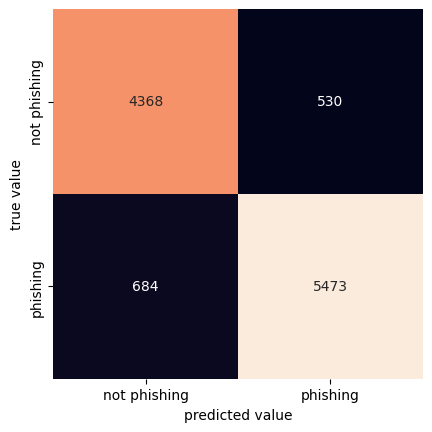

In [97]:
import seaborn as sns

# TO DO: Calculate confusion matrix (2 marks) : conf_mat
from sklearn.metrics import confusion_matrix, classification_report
conf_mat = confusion_matrix(y, y_pred)


# Below code prints confusion matrix using a heatmap
sns.heatmap(conf_mat, xticklabels=['not phishing', 'phishing'],  yticklabels=['not phishing', 'phishing'], square=True, annot=True, cbar=False, fmt='d')
plt.xlabel('predicted value')
plt.ylabel('true value')

In [98]:
# TO DO: Print classification report (2 marks)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

          -1       0.86      0.89      0.88      4898
           1       0.91      0.89      0.90      6157

    accuracy                           0.89     11055
   macro avg       0.89      0.89      0.89     11055
weighted avg       0.89      0.89      0.89     11055



### Questions (11 marks)
1. Is the dataset imbalanced? Does it affect model performance? (1 mark)
2. Does the model overfit or underfit for each of the 3 cases? (3 marks)
3. How do the training and testing accuracy change depending on the amount of data used? Explain with values. (1 mark)
4. In this case, what do a false positive and a false negative represent? Which one is worse? (2 marks)
5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this? (2 marks)
6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences? (2 mark)


ANSWER HERE
1. Yes the dataset is imbalanced. An imbalanced dataset can be bias toward the majority class meaning the model could miss minority classes and result in high false negatives.

2. Case 1 (X, y) is overfitting,
Case 2 (first two columns X and y) is underfitting, and
Case 3 (X_small and y_small) is overfitting

3. Training and testing accuracy are both affected by the amount of data. If more training data is available, the training accuracy and the testing accuracy improves.The model will tend to be more accurate on the training set. On the other hand, with limited training data, the training accuracy and the testing accuracy tend to be low or inconsistent, leading to overfitting or underfitting.

4. A false positive occurs when the model predicts falsely a positive class label that should be negative. A false negative occurs when the model predicts a negative class when it should actually belong to the positve class. In this case, a False negative would be when the model classifies a phising website as a legitimate one, which is worse as it can lead to security risks and the user trusting a website that is actually a malicious one.


5. We would want to maximize recall, to avoid having phishing websites flagged as legitimate.
We would want to minimize the amount of false negatives by lowering the threshold.

6. A lower log  loss indicates a better model performance, meaning it is making more accurate prediction. Between the 3 cases presented, the first (X,y) and the third cases (X_small, y_small) have low values of log loss meaning they are more accurate.

